In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

%matplotlib inline

# World earthquakes, clustering tutorial
# Data:  https://www.ngdc.noaa.gov/nndc/struts/form?t=101650&s=1&d=1
# Tectonic plates shapes:  http://legacy.jefferson.kctcs.edu/techcenter/gis%20data/World/Earthquakes/

# GET THE LATEST FILE OVER HTTP
import sys
print(sys.version_info)
# the file to get
urli = "https://www.ngdc.noaa.gov/nndc/struts/results?type_0=Exact&query_0=$ID&t=101650&s=13&d=189&dfn=signif.txt"
# file to save
outputti = "signif.txt"

if sys.version_info<(3,0,0):
        import urllib # python 2
        file = urllib.urlretrieve (urli, outputti)
else:
        import urllib.request # python 3+
        file = urllib.request.urlretrieve (urli, outputti)
        

# read the first line, parse to column labels
with open(outputti, 'r') as f:
    columns = f.readline().split("\t")
    
# read earthquakes to dataframe
qbc = pd.read_csv(outputti, sep="\t", header=None, names=columns)

# drop first row (double titles)
qbc.drop(0, inplace=True) 

# select columns
columns = ['YEAR', 'FOCAL_DEPTH', 'EQ_PRIMARY', 'LATITUDE', 'LONGITUDE']
qbc = pd.DataFrame(qbc, columns=columns)

# there are some empty strings, replace with none -> then drop
qbc['LATITUDE'].replace('       ', np.nan, inplace=True)

# drop rows with nan values from selected columns
qbc.dropna(subset = ['EQ_PRIMARY', 'LONGITUDE', 'LATITUDE'], inplace=True)

# convert strings to float (and int)
qbc.loc[:,['EQ_PRIMARY','LATITUDE', 'LONGITUDE']] = qbc.loc[:,['EQ_PRIMARY','LATITUDE', 'LONGITUDE']].astype('float')
qbc['YEAR'] = qbc['YEAR'].apply(int)


sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)


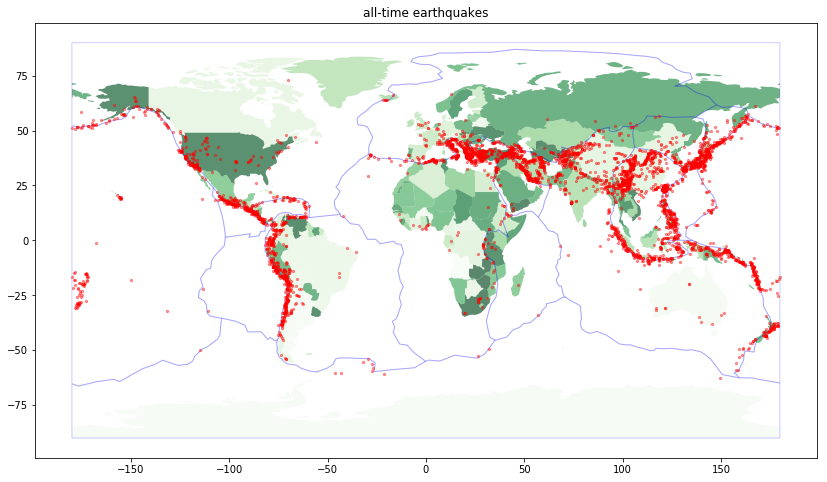

In [2]:
# load geopandas mapdata
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# check projection
#print(world.crs) 

# initialize
world = world.to_crs({'init': 'epsg:4326'}) # World Geodetic System 1984 (gps)

# Visualize
fig, ax = plt.subplots(figsize=(14,8))
ax.set_title("all-time earthquakes")
ax = world.plot(ax=ax, alpha=0.8, cmap='Greens')

# tectonic plates shapes from http://legacy.jefferson.kctcs.edu/techcenter/gis%20data/World/Earthquakes/
tectonic=gpd.read_file('plates/plates.shp') # tectonic plates shape file 
tectonic.plot(ax=ax, alpha=0.2, lw=1, edgecolor="blue", facecolor="white")

# quake plots
plt.scatter(qbc.LONGITUDE, qbc.LATITUDE, s=5, alpha = 0.4, color="red") #plt.plot(q.long, q.lat, 'rd', alpha=0.6, markersize=0.5)
plt.show()

### Limit examination area to north & south america and cluster earthquakes

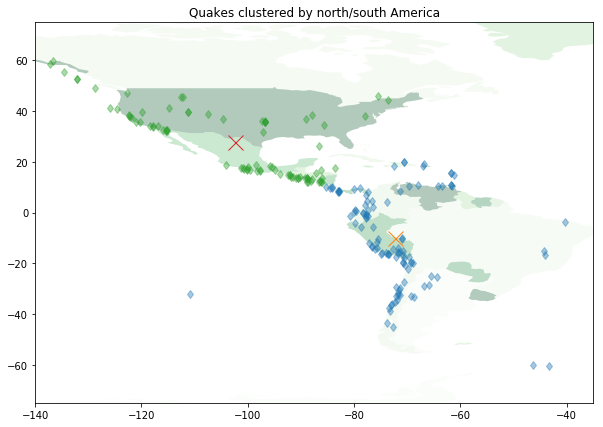

In [3]:
# drop nan values from depth
qbc.dropna(subset = ['FOCAL_DEPTH'], inplace=True)
# convert depth-values to float
qbc['FOCAL_DEPTH'] = qbc['FOCAL_DEPTH'].apply(float)

# limit the area to be examined to the American continent, years 2000-
limx = [-140,-35]
limy = [-75,75]
area = qbc.loc[(qbc['LONGITUDE'] > limx[0]) & 
               (qbc['LONGITUDE'] < limx[1]) & 
               (qbc['LATITUDE'] > limy[0]) & 
               (qbc['LATITUDE'] < limy[1]) &
               (qbc['YEAR'] > 1999)]


# import clustering from sklearn
from sklearn import cluster

# select 'lat' & 'long' for inputs
cols = ['LATITUDE', 'LONGITUDE']
x = area[cols].copy()

c = 2 # create 'c' clusters
kmeans = cluster.KMeans(n_clusters=c, max_iter=100)

# fit kmeans
kmeans.fit(x)

# get labels (0,1) , indicating which which cluster a point belongs to
labels = kmeans.labels_

# get centroids (the arithmetic mean position of all the points)
centroids = kmeans.cluster_centers_

# new column for cluster
x['cluster'] = labels

# Visualize
fig, ax = plt.subplots(figsize=(10,7))

# Zoom in
ax.set_xlim(limx)
ax.set_ylim(limy)

# world map
ax = world.plot(ax=ax, alpha=0.3, cmap='Greens')
ax.set_title("Quakes clustered by north/south America")


# plot clusters and centroids
for i in range(0,c):
    # select data by plates
    data = x.loc[x['cluster'] ==i]
    # plot the data observations
    plt.plot(data.iloc[:,1],data.iloc[:,0],'d', alpha=0.4)
    # plot the centroids
    lines = plt.plot(centroids[i,1], centroids[i,0],'x', ms=15)

plt.show()

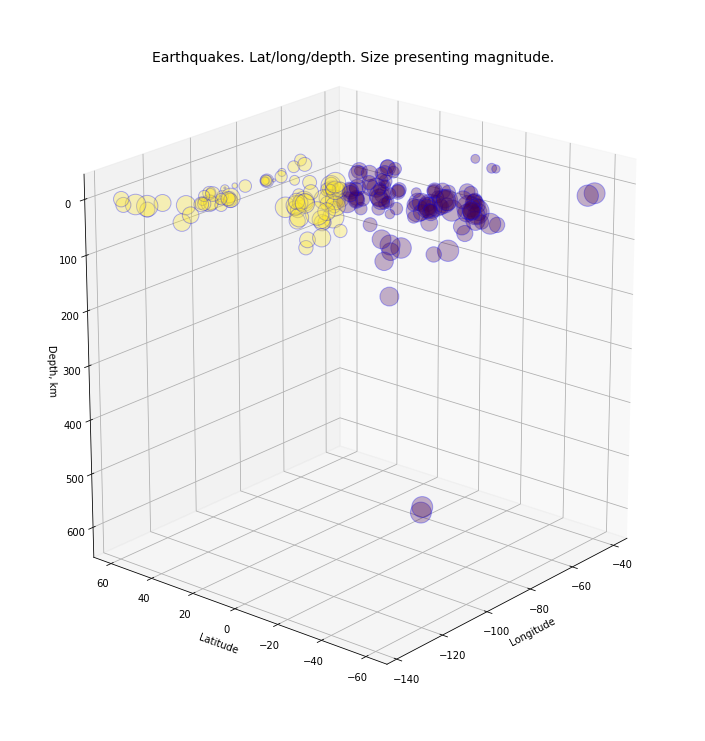

In [4]:
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

# select data 'lat, long, depth, cluster
cols = ['LATITUDE', 'LONGITUDE','FOCAL_DEPTH', 'EQ_PRIMARY']
data = pd.concat([area[cols], x['cluster']], axis=1)

#SCATTERPLOT 3D
fig = plt.figure(figsize=(10,10))

# 3d plot, elev & azim define the view angles
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=220)

#title
ax.set_title('Earthquakes. Lat/long/depth. Size presenting magnitude.', size=14)

# Lat , long , depth. Size presenting magnitude (weird error, had to use np.float64)
ax.scatter(data.iloc[:, 1], data.iloc[:, 0], data.iloc[:, 2], alpha=0.3, s=np.float64(data.EQ_PRIMARY)**3, c=data.cluster, edgecolor='b')

# invert depth
plt.gca().invert_zaxis()

# set axis labels
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_zlabel('Depth, km')
plt.show()

In [5]:
# Updated, recent earthquake data can be found from:
# https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php
# Past 30 days:  https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv


